In [1]:
import math
from scipy import integrate
import numpy
import pandas as pd
import os
import seaborn
import matplotlib.pyplot as plt

In [2]:
os.getcwd()
file = "Droplet analysis_new_20221013_151342.csv"

In [3]:
exp_data = pd.read_csv(file,
                  sep = ",",
                  header = 0)

exp_data = exp_data.drop(index=0)
exp_data.columns = ["Object Center X", "Object Center Y", "X Left", "Y Top", "X Right", "Y Bottom", "Area", "Orientation", "Frame #", "Time / s", "Aspect Ratio", "Pixel Threshold", "Max Droplet Width / um", "Contact Droplet Width / um", "Volume (slices) / um3", "Volume (cap) / um3", "Volume-equivalent radius / um", "Volume-equivalent diameter / um", "Height of spherical cap / um", "Contact angle / degrees", "Surface area / um2"
]

In [27]:
exp_data["Volume-equivalent contact radius / um"] = (abs((2*exp_data["Volume (slices) / um3"] / (math.pi*exp_data["Height of spherical cap / um"])) - (exp_data["Height of spherical cap / um"]**2)))**0.5

In [4]:
mass_solute = 2 # in g
mass_solvent = 8 # in g
mr_solute = 58.5 # in g mol-1
mr_solvent = 18 # in g mol-1
moles_solute = mass_solute / mr_solute
moles_solvent = mass_solvent / mr_solvent
mole_frac_solute = moles_solute / (moles_solute + moles_solvent)
mole_frac_solvent = moles_solvent / (moles_solute + moles_solvent)
mass_frac_solute = mass_solute / (mass_solute + mass_solvent)
mass_frac_solvent = mass_solvent / (mass_solute + mass_solvent)

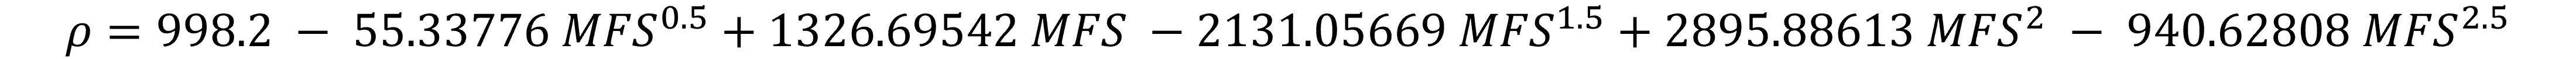

Density parameterisation. rho = density, MFS = mass fraction of solute

In [5]:
temp = 298 # in K
diffusion_coeff = 2.49E-05 # diffusion coefficient of water in air
vp =  2.34E+03 # vapour pressure of water
rh = 0.39 # relative humidity
timestep = 0.016 # in s
density = 998.2 - 55.33776*mass_frac_solute**0.5 + 1326.69542*mass_frac_solute - 2131.05669*mass_frac_solute**1.5 + 2895.88613*mass_frac_solute**2 - 940.62808*mass_frac_solute**2.5 # in kg m-3

In [6]:
radius = 0.0000212 # starting size in metres
ca_deg = exp_data["Contact angle / degrees"]
ca_rad = ca_deg * math.pi / 180

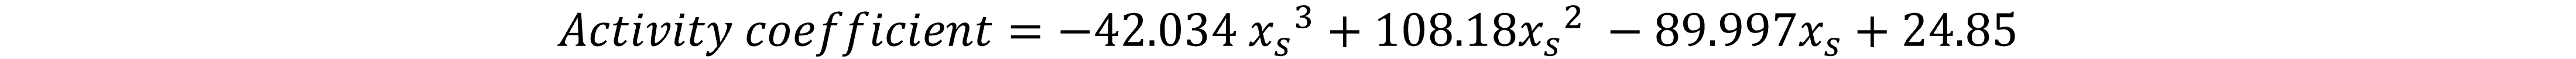

x<sub>s</sub> = mole fraction of solvent

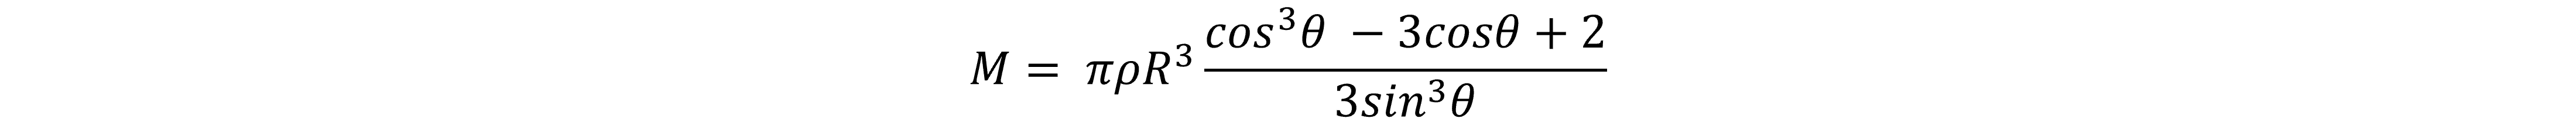

M = mass, rho = density, R = radius, theta = contact angle in radians

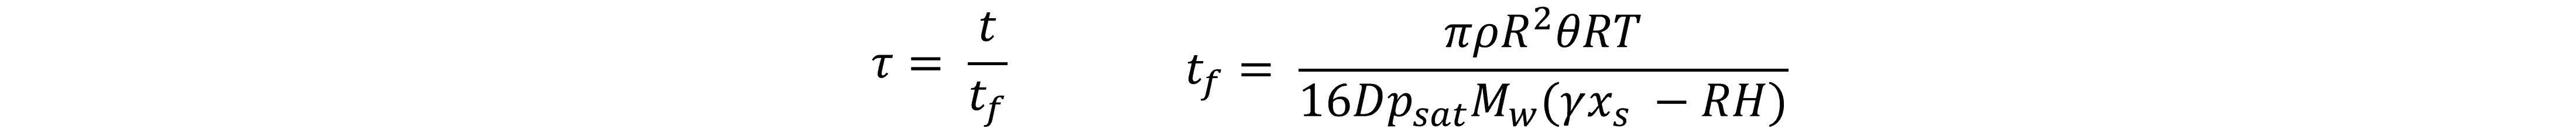

tau = dimensionless time, t = time, rho = density, R = radius, theta = contact angle in radians, D = diffusion coefficient of water in air, p<sub>sat</sub> = vapour pressure of water, M<sub>w</sub> = molar mass of water, gamma = activity coefficient, x<sub>s</sub> = mole fraction of solvent

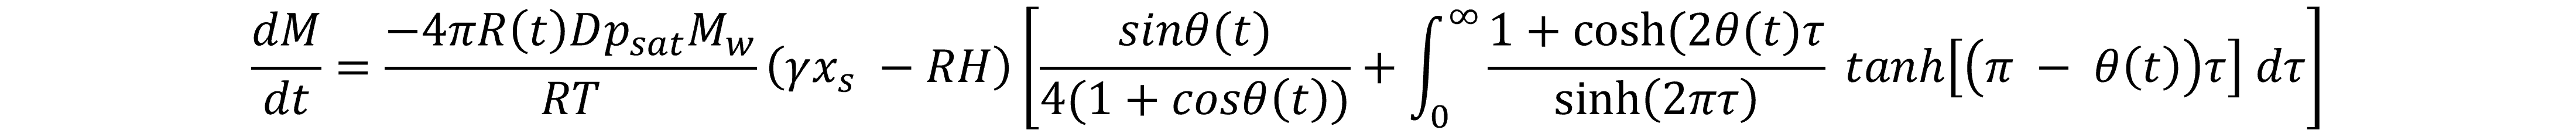

dM/dt = rate of mass loss, R(t) = time dependent radius, D = diffusion coefficient of water in air, p<sub>sat</sub> = vapour pressure of water, M<sub>w</sub> = molar mass of water, gamma = activity coefficient, x<sub>s</sub> = mole fraction of solvent, RH = relative humidity, theta(t) = time dependent theta, tau = dimensionless time

In [7]:
time_data = []
ca_rad_data = []
activity_coeff_data = []
mass_data = []
tau_data = []
dm_dt_data = []
new_mass_data = []
mass_frac_solute_data = []
mass_frac_solvent_data = []
density_data = []
radius_data = []

In [8]:
for i in range(1, len(exp_data.index)):

    activity_coeff = (-42.034*(mole_frac_solvent**3)) + (108.18*(mole_frac_solvent**2)) - (89.997*mole_frac_solvent) + 24.85

    mass = math.pi * density * radius**3 * (((math.cos(ca_rad[i])**3) - (3 * math.cos(ca_rad[i])) + 2) / (3*((math.sin(ca_rad[i]))**3)))

    tau = (timestep * i) / ((math.pi * density * (radius**2) * ca_rad[i] * 8.314 * temp) / (16 * diffusion_coeff * vp * (mr_solvent/1000) * ((mole_frac_solvent * activity_coeff) - rh)))

#dm_dt calculation, split into 3 parts (before square brackets, in brackets before integral, in brackets integral)
    part1 = (4 * math.pi * radius * (mr_solvent/1000) * diffusion_coeff * ((mole_frac_solvent * activity_coeff) - rh) * vp) / (8.314*temp)
    
    part2 = math.sin(ca_rad[i]) / (4 * (1 + math.cos(ca_rad[i])))

    part3 = integrate.quad(lambda tau: ((1 + math.cosh(2*ca_rad[i])*tau) / (math.sinh(2*math.pi*tau)) * (math.tanh((math.pi - ca_rad[i])*tau))), 0, 100)

    dm_dt = part1 * (part2 + part3[1])
    dm_dt_salt = 0

    new_mass = mass - (dm_dt * timestep)
    
    mass_frac_solute = (mass_frac_solute * mass - dm_dt_salt) / new_mass
    mass_frac_solvent = (mass_frac_solvent * mass - dm_dt * timestep) / new_mass
    mole_frac_solute = (mass_frac_solute / mr_solute) / ((mass_frac_solute / mr_solute) + (mass_frac_solvent / mr_solvent))
    mole_frac_solvent = (mass_frac_solvent / mr_solvent) / ((mass_frac_solute / mr_solute) + (mass_frac_solvent / mr_solvent))
    
    density = 998.2 - 55.33776*mass_frac_solute**0.5 + 1326.69542*mass_frac_solute - 2131.05669*mass_frac_solute**1.5 + 2895.88613*mass_frac_solute**2 - 940.62808*mass_frac_solute**2.5
    
    radius = (new_mass / (math.pi * density) * 3 * math.sin(ca_rad[i])**3 / ((math.cos(ca_rad[i])**3) - 3*math.cos(ca_rad[i]) + 2))**(1/3) 
    
    time_data.append(timestep * i)
    ca_rad_data.append(ca_rad[i])
    activity_coeff_data.append(activity_coeff)
    mass_data.append(mass)
    tau_data.append(tau)
    dm_dt_data.append(dm_dt)
    new_mass_data.append(new_mass)
    mass_frac_solute_data.append(mass_frac_solute)
    mass_frac_solvent_data.append(mass_frac_solvent)
    density_data.append(density)
    radius_data.append(radius * 10**6)

In [9]:
model_df = pd.DataFrame({"time": time_data, "ca_rad": ca_rad_data,"activity_coeff": activity_coeff_data,"mass": mass_data, "tau": tau_data, "dm/dt": dm_dt_data,"new_mass": new_mass_data, "mass_frac_solute": mass_frac_solute_data, "mass_frac_solvent": mass_frac_solvent_data, "density": density_data, "radius": radius_data})

In [13]:
model_df["volume"] = (model_df ["mass"] / model_df["density"]) * 10**18

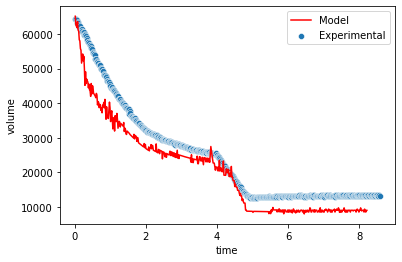

In [36]:
pd_new = pd.concat([exp_data, model_df], axis = 1)

seaborn.lineplot(data=model_df, x="time", y="volume", color="red", )
seaborn.scatterplot(data=exp_data, x= "Time / s", y ="Volume (slices) / um3")
plt.legend(labels=["Model", "Experimental"])


<AxesSubplot:xlabel='time', ylabel='radius'>

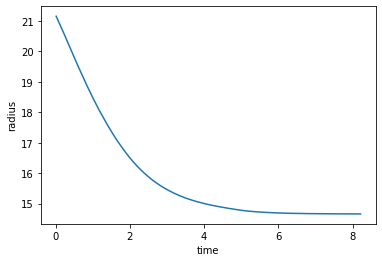

In [16]:
seaborn.lineplot(data=model_df, x="time", y="radius")